In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.externals import joblib
import pandas as pd 
from sklearn.model_selection import train_test_split
import torch
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data 
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

### Load datasets

In [2]:
#path = 'movielens-20m-dataset'
path = 'ml-latest-small'
print("===========================================================")
print("Loading ratings")
rating = pd.read_csv("./"+path+"/rating.csv")
print(rating[:3])
rating = np.array(rating)
print("===========================================================")
print("Loading movies")
movie = pd.read_csv("./"+path+"/movie.csv")
print(movie[:3])
movie = np.array(movie)
print("===========================================================")
print("Loading tags")
tag = pd.read_csv("./"+path+"/tag.csv")
print(tag[:3])
tag = np.array(tag)
print("===========================================================")
print("Loading genome_scores")
genome_scores = pd.read_csv("./"+path+"/genome_scores.csv")
print(genome_scores[:3])
genome_scores = np.array(genome_scores)
print("===========================================================")
print("Loading genome_tags")
genome_tags = pd.read_csv("./"+path+"/genome_tags.csv")
print(genome_tags[:3])
genome_tags = np.array(genome_tags)
print("===========================================================")
print("Ok (*^_^*)")

Loading ratings
   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
Loading movies
   movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
Loading tags
   userId  movieId                      tag   timestamp
0      15      339  sandra 'boring' bullock  1138537770
1      15     1955                  dentist  1193435061
2      15     7478                 Cambodia  1170560997
Loading genome_scores
   movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775
Loading genome_tags
   tagId           tag
0      1           007
1      2  007 (seri

### get n_user & n_movie

In [3]:
print("movie.shape",movie.shape)  
users1 = np.unique(rating[:,0])
print("users who rated movies:",users1.shape)  
users2 = np.unique(tag[:,0])
print("users who taged movies",users2.shape)  
users = np.unique(np.hstack((users1,users2)))
print("number of users:",users.shape) 

movie.shape (9125, 3)
users who rated movies: (671,)
users who taged movies (61,)
number of users: (671,)


In [4]:
n_user = users.shape[0]
n_movie = movie.shape[0]

### Form data with shape (userid, movieid, relations)

In [5]:
n_f = 3
X = torch.Tensor(n_user,n_movie, n_f)  # | rate ########| mean_rate | XXXtag | XXXrelevance | genre(int) |

In [6]:
matrix_rate = np.ones((rating.shape[0],2))
print(matrix_rate.shape)
#mean_rate
print(rating.shape) #(20000263, 4)
for i in range(rating.shape[0]):
    movieId,rate = rating[i,1:3]
    movieId = movieId.astype(int)
    if(movieId <= n_movie and rate != str):
        matrix_rate[movieId-1,0] = matrix_rate[movieId-1,0] + rate
        matrix_rate[movieId-1,1] = matrix_rate[movieId-1,1] + 1
    if(i%1000000 == 0):
        print(i)
mean_rate = matrix_rate[:,0]/matrix_rate[:,1]
#mean_rate.shape #(20000263,)

(100004, 2)
(100004, 4)
0


In [7]:
#save user's rate
for i in range(rating.shape[0]):
    userId,movieId,rate = rating[i,0:3]
    movieId = movieId.astype(int)
    if(movieId <= n_movie and rate != str):   #有的rating里的movieId,MOVIE表里没有
        X[userId - 1,movieId - 1,0] = rate
    if(i%1000000 == 0):
        print(i)

0


In [8]:
#save mean_rate 巨慢。。。

for i in range(n_movie):
    X[:,i,1] = mean_rate[i]
    if(i%1000000 == 0):
        print(i)

0


In [9]:
#save user's tag： tensor里只能存同一种数据类型的变量
#超级慢。。
#for i in range(tag.shape[0]):
#    userId,movieId,tag_desc = tag[i,0:3]
#    #判断tagId是否存在
#    if(np.where(genome_tags[:,1] == tag_desc)[0].size != 0):
#        tagId = np.where(genome_tags == tag_desc)[0][0]
#        if(movieId <= n_movie ):   #有的rating里的movieId,MOVIE表里没有
#            X[userId - 1,movieId - 1,2] = float(tagId)
#            '''for j in range(genome_scores.shape[0]):
#                if(genome_scores[j,0] == movieId and genome_scores[j,1] == tagId):
#                    X[userId - 1,movieId - 1,3] = genome_scores[j,2]'''
#    if(i%10000 == 0):
#        print(i)

In [10]:
genre_list = np.array(['Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'])

In [11]:
#save genre
for i in range(movie.shape[0]):
    movieId, genres = movie[i,(0,2)]
    genres_split = genres.split('|')
    for genre in genres_split:
        x = 0
        index = np.where(genre_list ==genre)[0]
        if(index.size > 0):
            x = x + 2**index
    if(movieId <= n_movie ):
        X[:,movieId - 1,2] = float(x)

In [12]:
X_org = X.clone()
#normalize data
Xmean = torch.mean(X, 1, True)
Xstd = torch.var(X, 1, True)
torchvision.transforms.Normalize(Xmean, Xstd)(X)
print(X)


( 0  ,.,.) = 
 -3.5238e-01  1.5844e+00 -2.0074e-05
 -3.5238e-01  1.1485e+00 -2.0074e-05
 -3.5238e-01  9.1786e-01 -8.1268e-07
                 ⋮                  
 -3.5238e-01 -1.0070e+00 -2.0696e-05
 -3.5238e-01 -1.0070e+00 -2.0696e-05
 -3.5238e-01 -1.0070e+00 -2.0696e-05

( 1  ,.,.) = 
 -2.7112e-01  1.5844e+00 -2.0074e-05
 -2.7112e-01  1.1485e+00 -2.0074e-05
 -2.7112e-01  9.1786e-01 -8.1268e-07
                 ⋮                  
 -2.7112e-01 -1.0070e+00 -2.0696e-05
 -2.7112e-01 -1.0070e+00 -2.0696e-05
 -2.7112e-01 -1.0070e+00 -2.0696e-05

( 2  ,.,.) = 
 -2.7212e-01  1.5844e+00 -2.0074e-05
 -2.7212e-01  1.1485e+00 -2.0074e-05
 -2.7212e-01  9.1786e-01 -8.1268e-07
                 ⋮                  
 -2.7212e-01 -1.0070e+00 -2.0696e-05
 -2.7212e-01 -1.0070e+00 -2.0696e-05
 -2.7212e-01 -1.0070e+00 -2.0696e-05
 ... 

(668 ,.,.) = 
 -2.7905e-01  1.5844e+00 -2.0074e-05
 -2.7905e-01  1.1485e+00 -2.0074e-05
 -2.7905e-01  9.1786e-01 -8.1268e-07
                 ⋮                  
 -2.7905e

# Training process

### Train the encoder

How to make encoded vectors have 'round' boundaries for each cluster????

In [13]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(9125*3, 90)
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(90, 9125*3)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

autoencoder = AutoEncoder()

In [14]:
print(autoencoder)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=27375, out_features=90, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=90, out_features=27375, bias=True)
  )
)


In [32]:
from torch.optim.optimizer import Optimizer, required

class MySGD(Optimizer):
    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay1=0, weight_decay2=0, nesterov=False):
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay1=weight_decay1, weight_decay2=weight_decay2, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(MySGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(MySGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay1 = group['weight_decay1']
            weight_decay2 = group['weight_decay2']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay1 != 0:
                    d_p.add_(weight_decay1, torch.sign(p.data))
                if weight_decay2 != 0:
                    d_p.add_(weight_decay2, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                        buf.mul_(momentum).add_(d_p)
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(-group['lr'], d_p)

        return loss

### with L1 regu

In [34]:
LR = 0.0001
EPOCH = 10

AELoss = []
optimizer = MySGD(autoencoder.parameters(), weight_decay1=0.001, lr=LR,momentum=0.9)
loss_func = nn.MSELoss()

def orth_l1(W):
    I = torch.diag(W.size()[0])
    return torch.sum(W.mm(W.transpose())-I)

for epoch in range(EPOCH):
    X_tr = Variable(X.view(-1, 9125*3))
    
    encoded, decoded = autoencoder(X_tr)

    loss = loss_func(decoded, X_tr)      # mean square error
    AELoss.append(loss.data[0])
    if epoch%10==0:
        print('epoch:',epoch,', loss:', loss.data[0])
    optimizer.zero_grad()               # clear gradients for this training step
    loss.backward()                     # backpropagation, compute gradients
    optimizer.step()                    # apply gradients   

epoch: 0 , loss: 5.4288201332092285
epoch: 1 , loss: 5.426554203033447
epoch: 2 , loss: 5.422299861907959
epoch: 3 , loss: 5.416068077087402
epoch: 4 , loss: 5.408793926239014
epoch: 5 , loss: 5.400267601013184
epoch: 6 , loss: 5.391228199005127
epoch: 7 , loss: 5.381555557250977
epoch: 8 , loss: 5.37239408493042
epoch: 9 , loss: 5.363414287567139


### with L2 regu

In [21]:
LR = 0.01
EPOCH = 100

AELoss = []
optimizer = torch.optim.SGD(autoencoder.parameters(), weight_decay=0.001, lr=LR,momentum=0.9)
loss_func = nn.MSELoss()

for epoch in range(EPOCH):
    X_tr = Variable(X.view(-1, 9125*3))
    
    encoded, decoded = autoencoder(X_tr)

    loss = loss_func(decoded, X_tr)      # mean square error
    AELoss.append(loss.data[0])
    if epoch%10==0:
        print('epoch:',epoch,', loss:', loss.data[0])
    optimizer.zero_grad()               # clear gradients for this training step
    loss.backward()                     # backpropagation, compute gradients
    optimizer.step()                    # apply gradients   

epoch: 0 , loss: 4.9680657386779785
epoch: 1 , loss: 4.967865467071533
epoch: 2 , loss: 4.967511177062988
epoch: 3 , loss: 4.967039108276367
epoch: 4 , loss: 4.966395378112793
epoch: 5 , loss: 4.965687274932861
epoch: 6 , loss: 4.964868545532227
epoch: 7 , loss: 4.964041709899902
epoch: 8 , loss: 4.963265895843506
epoch: 9 , loss: 4.962388038635254
epoch: 10 , loss: 4.9615159034729
epoch: 11 , loss: 4.960652828216553
epoch: 12 , loss: 4.959858417510986
epoch: 13 , loss: 4.9591240882873535
epoch: 14 , loss: 4.958434581756592
epoch: 15 , loss: 4.957735538482666
epoch: 16 , loss: 4.957118988037109
epoch: 17 , loss: 4.956523418426514
epoch: 18 , loss: 4.9560441970825195
epoch: 19 , loss: 4.955591201782227
epoch: 20 , loss: 4.955132007598877
epoch: 21 , loss: 4.9547247886657715
epoch: 22 , loss: 4.954334259033203
epoch: 23 , loss: 4.953993797302246
epoch: 24 , loss: 4.953683853149414
epoch: 25 , loss: 4.9534125328063965
epoch: 26 , loss: 4.953122615814209
epoch: 27 , loss: 4.952850341796875

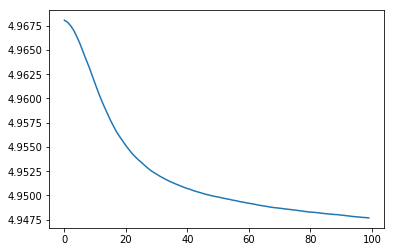

In [22]:
plt.plot(range(len(AELoss)),AELoss) 

In [47]:
torch.save(autoencoder, 'autoencoder.pkl')

C:\Users\chenz\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\torch\serialization.py:159: UserWarning: Couldn't retrieve source code for container of type AutoEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Use kmeans with hinden features we found above to cluster users

In [18]:
autoencoder = torch.load('autoencoder.pkl')

In [23]:
encoded, _ = autoencoder(X_tr)
hf = encoded.data.numpy()

How many user groups ?????

In [24]:
n_clusters = 9

kmeans = KMeans(n_clusters=n_clusters).fit(hf)

In [56]:
joblib.dump(kmeans, "kmeans.m")

['kmeans.m']

In [25]:
User_label = kmeans.labels_
User_mean = kmeans.cluster_centers_

In [26]:
np.where(np.array(User_label)==1)

(array([  3,   4,   5,   6,  11,  14,  16,  18,  19,  20,  21,  22,  27,
         29,  32,  33,  34,  36,  38,  40,  42,  44,  45,  47,  48,  50,
         51,  52,  55,  56,  57,  59,  60,  62,  64,  65,  66,  67,  68,
         72,  73,  74,  75,  76,  77,  80,  82,  85,  87,  89,  92,  94,
         95,  97,  98, 101, 102, 104, 105, 110, 112, 114, 116, 117, 118,
        119, 122, 124, 127, 128, 129, 130, 131, 133, 136, 138, 141, 147,
        148, 149, 151, 152, 154, 155, 156, 157, 158, 159, 163, 164, 165,
        166, 168, 169, 170, 172, 173, 174, 175, 176, 178, 179, 180, 181,
        184, 186, 188, 189, 192, 194, 195, 196, 197, 198, 199, 200, 201,
        205, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 221,
        223, 226, 227, 228, 231, 233, 234, 235, 237, 238, 239, 241, 242,
        244, 246, 247, 252, 253, 254, 256, 257, 258, 261, 262, 263, 264,
        267, 268, 269, 274, 275, 277, 280, 281, 282, 284, 285, 286, 288,
        289, 290, 291, 292, 293, 294, 295, 296, 297

### Store movies for each cluster
Use what features to sort movies? How to store and reload this list???

In [27]:
movies = []
X_n = X.numpy()
for i in range(n_clusters):
    usersi = X_n[np.array(User_label)==i,:,0]  ### get all users in i cluster, features: rate
    SuperUseri = np.sum(usersi,0) ###sum up all user's rating for i cluster
    mvid = np.argsort(-SuperUseri,0)
    movies.append(mvid)
print(movies)

[array([ 456,  589,  355, ..., 3133, 3127, 9124], dtype=int64), array([ 259,  355, 2857, ..., 6390,  867, 9124], dtype=int64), array([ 295,  479,  587, ..., 3359, 3373, 9124], dtype=int64), array([ 540, 1198, 1355, ..., 3063, 3057, 9124], dtype=int64), array([1370, 1128,   30, ..., 3107, 3101, 9124], dtype=int64), array([ 779,  647,   31, ..., 3224, 3218, 9124], dtype=int64), array([ 777, 2570, 6501, ..., 3052, 3046, 9124], dtype=int64), array([ 317,  295, 2958, ..., 3476, 3436, 9124], dtype=int64), array([4225, 2570, 3990, ..., 3051, 3045, 9124], dtype=int64), array([ 259, 2570, 1195, ..., 3301, 3316, 9124], dtype=int64)]


In [39]:
np.savetxt("filename.txt",movies)

In [40]:
b = np.loadtxt("filename.txt")
print(b)

[[ 456.  589.  355. ... 3133. 3127. 9124.]
 [ 259.  355. 2857. ... 6390.  867. 9124.]
 [ 295.  479.  587. ... 3359. 3373. 9124.]
 ...
 [ 317.  295. 2958. ... 3476. 3436. 9124.]
 [4225. 2570. 3990. ... 3051. 3045. 9124.]
 [ 259. 2570. 1195. ... 3301. 3316. 9124.]]


### Word cloud for each cluster

C:\Users\chenz\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


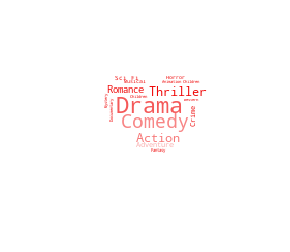

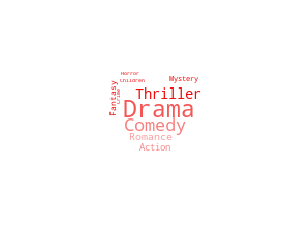

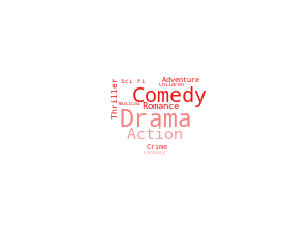

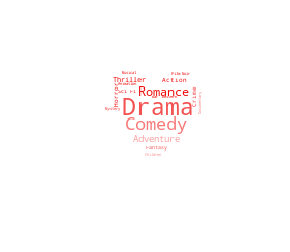

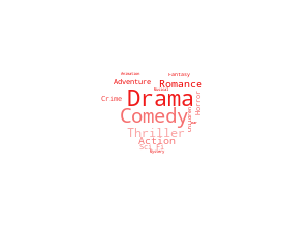

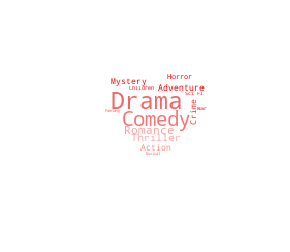

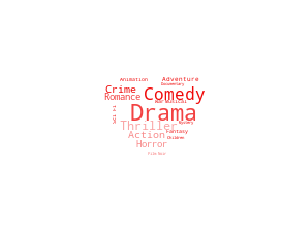

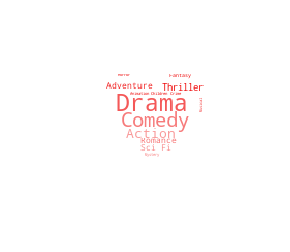

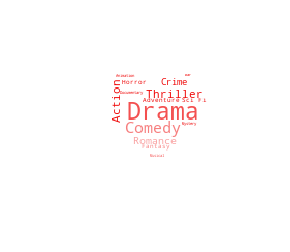

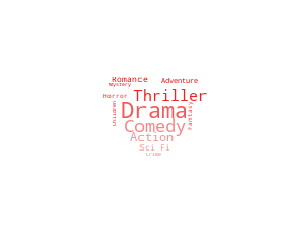

In [76]:
from wordcloud import WordCloud, ImageColorGenerator
from scipy.misc import imread
back_coloring = imread("love.jpg")
i = 1
for clus in movies:
    m_clus = movie[clus[:100],2]
    wl_space_split = " ".join(m_clus)
    replaced = wl_space_split.replace("|"," ")
    result = ' '.join(replaced.split())
    my_wordcloud = WordCloud(background_color="white",mask=back_coloring).generate(result)
    image_colors = ImageColorGenerator(back_coloring)
    plt.figure(i)
    plt.imshow(my_wordcloud.recolor(color_func=image_colors))
    plt.axis("off")
    i +=1

# Testing/Recommendation

### Find movies for a user by choosing high related movie watched by other users in the same cluster
X_ts should in shape (userid, movieid, features)

In [71]:
def rcmd(X_ts,X_ts_norm):
    #Load models
    autoencoder = torch.load('autoencoder.pkl')
    kmeans = joblib.load("kmeans.m")
    
    
    #find watched movie in movie list for users
    rate = X_ts.numpy()[:,:,0]
 
    #encoder
    encoded, _ = autoencoder(Variable(X_ts_norm.view(-1, 9125*3)))
    hf = encoded.data.numpy()
    #kmeans
    user_label = kmeans.predict(hf)
    #movie list
    movies = np.loadtxt("mvrcmdlist.txt")
    rcmdlist = []
    for u in range(len(X_ts)):
        rcmd = movies[user_label[u]-1].copy()
        uwatched = list(np.where(rate[u,:]!=0))
        for mv in uwatched:
            if mv in rcmd: rcmd.remove(mv)
        rcmdlist.append(rcmd)
        
    #recommend first 10 movies for each user
    return np.array(rcmdlist,dtype=int)[:,:10]

X_ts = X_org[:3].clone()
X_ts_norm = X[:3].clone()
rcmdlist = rcmd(X_ts,X_ts_norm)
for i in range(len(rcmdlist)):
    print('===========================================')
    print('===========================================')
    print('For user ',i+1)
    for j in range(len(rcmdlist[0])):
        print('Movie name: ',movie[rcmdlist[i,j],1],' ||genres: ',movie[rcmdlist[i,j],2])

For user  1
Movie name:  Defying Gravity (1997)  ||genres:  Drama
Movie name:  Delta of Venus (1995)  ||genres:  Drama
Movie name:  Wallace & Gromit: The Best of Aardman Animation (1996)  ||genres:  Adventure|Animation|Comedy
Movie name:  Tales from the Hood (1995)  ||genres:  Action|Crime|Horror
Movie name:  Only You (1994)  ||genres:  Comedy|Romance
Movie name:  Street Fighter (1994)  ||genres:  Action|Adventure|Fantasy
Movie name:  Smilla's Sense of Snow (1997)  ||genres:  Drama|Thriller
Movie name:  Crooklyn (1994)  ||genres:  Comedy|Drama
Movie name:  Substitute, The (1996)  ||genres:  Action|Crime|Drama
Movie name:  Gothic (1986)  ||genres:  Drama|Horror
For user  2
Movie name:  Crooklyn (1994)  ||genres:  Comedy|Drama
Movie name:  William Shakespeare's Romeo + Juliet (1996)  ||genres:  Drama|Romance
Movie name:  Snow White and the Seven Dwarfs (1937)  ||genres:  Animation|Children|Drama|Fantasy|Musical
Movie name:  Only You (1994)  ||genres:  Comedy|Romance
Movie name:  Breakdow

C:\Users\chenz\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
